# DATASET **BOSTON House Prices**

Dadas las características de una casa, hay que calcular su precio de venta.

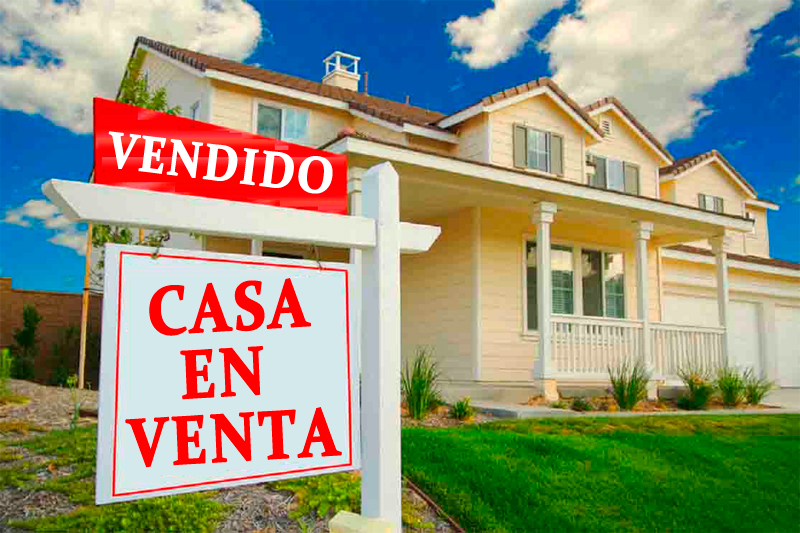

Las muestras contienen 13 atributos de casas en diferentes lugares de los suburbios de Boston a fines de la década de 1970. El valor objetivo es el valor procedio de las casas en una ubicación (en k$)

Variables en orden:
 1. CRIM     per capita crime rate by town
 1. ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 1. INDUS    proportion of non-retail business acres per town
 1. CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 1. NOX      nitric oxides concentration (parts per 10 million)
 1. RM       average number of rooms per dwelling
 1. AGE      proportion of owner-occupied units built prior to 1940
 1. DIS      weighted distances to five Boston employment centres
 1. RAD      index of accessibility to radial highways
 1. TAX      full-value property-tax rate per $10,000
 1. PTRATIO  pupil-teacher ratio by town B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

 1. LSTAT    % lower status of the population
 1. MEDV     Median value of owner-occupied homes in $1000's

In [ ]:
import tensorflow as tf
import keras
import time
from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [ ]:
(X_train, y_train), (X_test, y_test)= tf.keras.datasets.boston_housing.load_data( path="boston_housing.npz", test_split=0.2, seed=113 )

57026/57026 [==============================] - 0s 0us/step


# Explorar el dataset

In [ ]:
print(f"X train: {X_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y train: {y_train.shape}")
print(f"y test: {y_test.shape}")

X train: (404, 13)
X test: (102, 13)
y train: (404,)
y test: (102,)




---



---



# Exploración de los datos

Primero vamos a convertir nuestra matriz de numpy en un DataFrame

In [ ]:
cols = ["crim", "zn", "indus", "chas", "nox",
        "rm", "age", "dis", "rad", "tax", "ptratio", "lstat", "medv"]

In [ ]:
df = pd.DataFrame(X_train, columns=cols)
df["price"] = y_train
df.head(3)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,price
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0


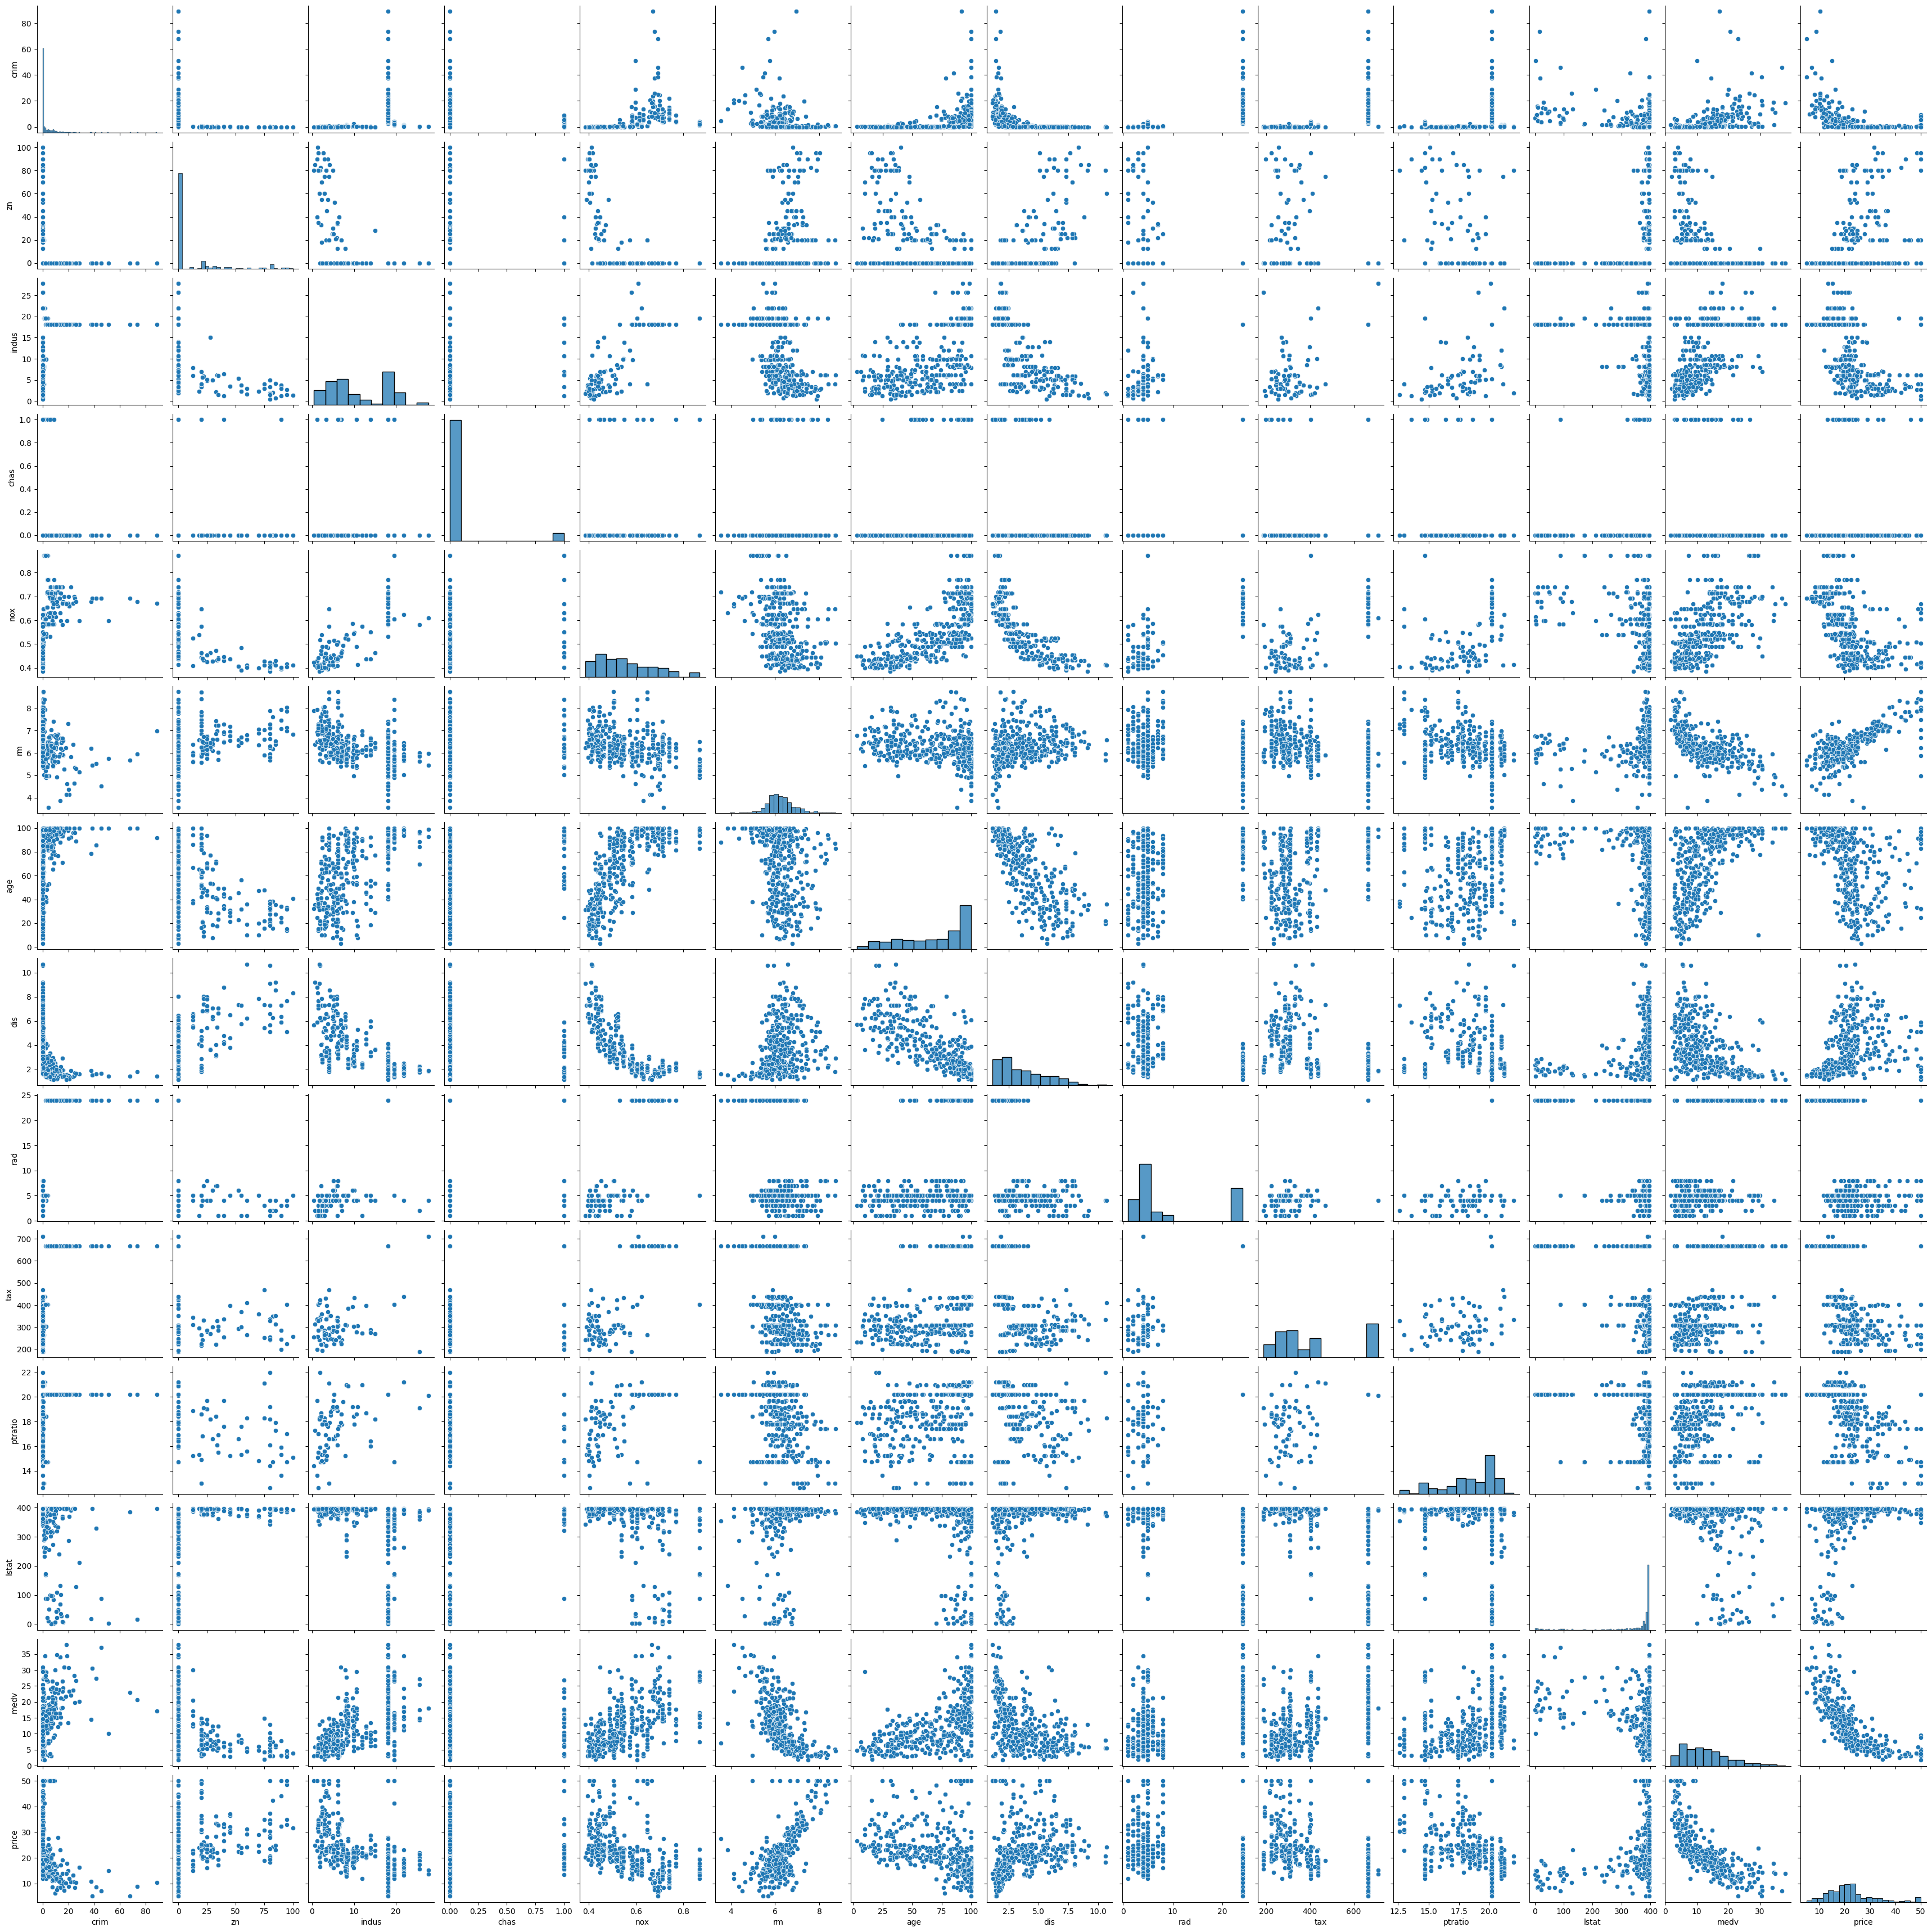

In [ ]:
sns.pairplot(df)
plt.show()

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

vars = cols.copy()
vars.remove("chas")
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

In [ ]:
df.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,price
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817,22.395050
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545,9.210442
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000,16.675000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000,20.750000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500,24.800000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


# Limpieza de datos

## Datos faltantes

In [ ]:
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
lstat      0
medv       0
price      0
dtype: int64

No tenemos ningún dato faltante

## Filtrar outliers

In [ ]:
from scipy import stats

dfs = {
    # Filtramos datos más allá de tres desviaciones estandar
    "sin outliers" : df[(np.abs(stats.zscore(df)) < 4.0).all(axis=1)]
}

In [ ]:
dfs["sin outliers"].describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv,price
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,2.874830,11.653266,10.998970,0.062814,0.555643,6.275090,68.600503,3.773232,9.221106,401.977387,18.450000,357.069724,12.592990,22.595226
std,5.593322,23.904388,6.807666,0.242934,0.117260,0.706606,27.939909,2.027412,8.576305,164.502156,2.206639,90.539875,7.133999,9.124852
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000,5.000000
25%,0.079870,0.000000,5.130000,0.000000,0.453000,5.879250,45.025000,2.111050,4.000000,279.000000,17.000000,375.240000,6.777500,17.025000
50%,0.260420,0.000000,8.560000,0.000000,0.538000,6.208500,77.550000,3.215700,5.000000,329.500000,19.000000,391.385000,11.300000,21.000000
75%,2.808720,12.500000,18.100000,0.000000,0.629250,6.615000,93.975000,5.188425,8.000000,616.750000,20.200000,396.192500,16.860000,24.800000
max,38.351800,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
vars = cols.copy()
vars.remove("chas")
fig = make_subplots(rows=1, cols=len(vars))
for i, var in enumerate(vars):
    fig.add_trace(
        go.Box(y=dfs["sin outliers"][var],
        name=var),
        row=1, col=i+1
    )

fig.update_traces(boxpoints='all', jitter=.3)

In [ ]:
print(f"Limpiando outliers hemos quitado {df.shape[0] - dfs['sin outliers'].shape[0]} datos")

Limpiando outliers hemos quitado 6 datos


## Verificar duplicados

In [ ]:
dfs["sin outliers"].duplicated().sum()

0

# Preprocesamiento de los datos

## Separar datos en características y target

In [ ]:
X, y = dfs["sin outliers"].drop(columns=["price"]).values, dfs["sin outliers"]["price"].values

In [ ]:
print(X.dtype, X.shape)
print(y.dtype, y.shape)

float64 (398, 13)
float64 (398,)


## Escalar datos utilizando `RobustScaler`

Utilizaré RobustScaler ya que los datos siguen teniendo valores dispersos en algunas columnas. Por ejemplo, el Q3 de la columna `crim` es 2.8 y el valor máximo es 38.35

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaler.fit(X)
X_std = scaler.transform(X)
X_test_std = scaler.transform(X_test)
print("Los datos han sido escalados")

Los datos han sido escalados


In [ ]:
from sklearn.model_selection import train_test_split

X_train_std, X_val_std, y_train, y_val = train_test_split(X_std, y, test_size=0.15, random_state=11)
print(X_train_std.shape, y_train.shape)
print(X_val_std.shape, y_val.shape)

(338, 13) (338,)
(60, 13) (60,)


# Modelo básico

In [ ]:
model = Sequential([
    Dense(16, activation="relu", input_shape=(X_std.shape[1],)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(8, activation="relu"),

    # Neurona de salida con ReLU (probando sale mejor que lineal)
    Dense(1, activation="relu"),
])

opt = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model.compile(optimizer=opt, loss="mse", metrics=["mae", "mape"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1441 (5.63 KB)
Trainable params: 1441 (5.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Entrenar modelo

In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=10, verbose=1,
        restore_best_weights=True, start_from_epoch=100),
    keras.callbacks.ModelCheckpoint(
        filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor="val_loss", mode="min"),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=10,
        verbose=1,
        mode="min",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.00001,
    )
]

hist = model.fit(
    X_train_std, y_train, epochs=50, batch_size=16,
    validation_data=(X_val_std, y_val), verbose=1, callbacks=my_callbacks,
)

Epoch 1/50
22/22 [==============================] - 1s 11ms/step - loss: 588.9016 - mae: 22.5353 - mape: 98.9664 - val_loss: 533.2126 - val_mae: 21.1094 - val_mape: 96.4646 - lr: 0.0010
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 554.7657 - mae: 21.7233 - mape: 94.5449 - val_loss: 472.4171 - val_mae: 19.4840 - val_mape: 86.4023 - lr: 0.0010
Epoch 3/50
 1/22 [>.............................] - ETA: 0s - loss: 442.4483 - mae: 19.8550 - mape: 91.9133

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



22/22 [==============================] - 0s 4ms/step - loss: 464.6959 - mae: 19.4296 - mape: 82.5729 - val_loss: 339.3544 - val_mae: 15.5635 - val_mape: 67.9876 - lr: 0.0010
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 317.8860 - mae: 15.0451 - mape: 63.6091 - val_loss: 210.5686 - val_mae: 11.7585 - val_mape: 59.4853 - lr: 0.0010
Epoch 5/50
22/22 [==============================] - 0s 3ms/step - loss: 218.5838 - mae: 11.9729 - mape: 54.6140 - val_loss: 182.1028 - val_mae: 10.7996 - val_mape: 57.6798 - lr: 0.0010
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 171.7002 - mae: 10.3468 - mape: 47.3477 - val_loss: 142.8468 - val_mae: 9.2043 - val_mape: 47.5684 - lr: 0.0010
Epoch 7/50
22/22 [==============================] - 0s 3ms/step - loss: 128.4848 - mae: 8.7618 - mape: 39.1903 - val_loss: 114.4321 - val_mae: 8.0220 - val_mape: 42.4709 - lr: 0.0010
Epoch 8/50
22/22 [==============================] - 0s 3ms/step - loss: 89.1302 - mae: 7.

In [ ]:
loss, mae, mape = model.evaluate(X_val_std, y_val)

2/2 [==============================] - 0s 5ms/step - loss: 21.2597 - mae: 3.1531 - mape: 17.7799


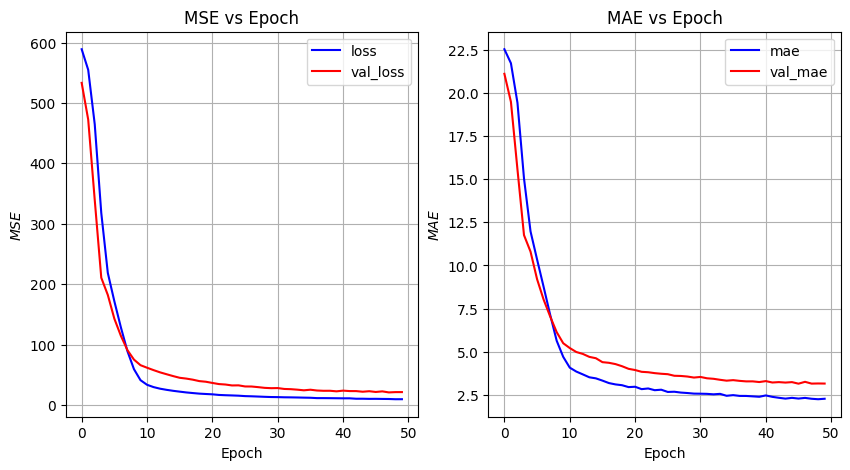

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot( hist.epoch, hist.history['loss'],     'b',label='loss')
plt.plot( hist.epoch, hist.history['val_loss'], 'r',label='val_loss')
plt.title(u'MSE vs Epoch')
plt.xlabel(u'Epoch')
plt.ylabel(r'$MSE$')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot( hist.epoch, hist.history['mae'],     'b',label='mae')
plt.plot( hist.epoch, hist.history['val_mae'], 'r',label='val_mae')
plt.title(u'MAE vs Epoch')
plt.xlabel(u'Epoch')
plt.ylabel(r'$MAE$')
plt.legend(loc='upper right')
plt.grid(True)

# plt.ylim([0, np.max(hist.history['loss'])])
plt.show()
plt.savefig("mse_y_mae_por_epochs.jpg", dpi=100)
plt.clf()

# Keras tuner

In [ ]:
try:
    import keras_tuner as kt
except ImportError:
    !pip install -q -U keras-tuner
    import keras_tuner as kt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00


In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(keras.layers.Input(shape=(X_train.shape[1],)))

        # Tune the number of layers.
        for i in range(hp.Int("num_layers", 1, 6)):
            model.add(
                Dense(
                    # Tune number of units separately.
                    # https://keras.io/api/keras_tuner/hyperparameters/#int-method
                    units = hp.Int(
                        f'units_{i}',
                        min_value=8,
                        max_value=128,
                        step=2,
                        sampling="log", # Potencias de 2, valores posibles son
                        # [8, 16, 32, 64, 128] "log": min_value * (max_value / min_value) ^ value
                    ),
                    activation = hp.Choice(
                        f"activation_{i}", ['LeakyReLU','relu']
                    ),
                )
            )

        model.add(Dense(1, activation="relu", name = 'prediccion'))  # <---- capa de salida (REGRESIÓN)

        lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

        optimizers_dict = {
            "Adam":    keras.optimizers.Adam(learning_rate=lr),
            "SGD":     keras.optimizers.SGD(learning_rate=lr),
            # "Adagrad": keras.optimizers.Adagrad(learning_rate=lr)
        }

        hp_optimizers = hp.Choice(
            'optimizer',
            values=[ "SGD", "Adam"]
        )

        model.compile(
            optimizer = optimizers_dict[hp_optimizers],
            loss = "mse",
            metrics = ["mae", "mape"]
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size = hp.Choice("batch_size", [8, 16, 32]),
            **kwargs,
        )

In [ ]:
MyHyperModel(kt.HyperParameters())

In [ ]:
tuner = kt.Hyperband( # https://keras.io/api/keras_tuner/tuners/hyperband/
    MyHyperModel(),
    objective            = "val_loss",
    executions_per_trial = 1,
    max_epochs           = 200,
    factor               = 3,
    directory            = 'salida',
    project_name         = 'hp_tune',
    overwrite            = True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 2, 'sampling': 'log'}
activation_0 (Choice)
{'default': 'LeakyReLU', 'conditions': [], 'values': ['LeakyReLU', 'relu'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
optimizer (Choice)
{'default': 'SGD', 'conditions': [], 'values': ['SGD', 'Adam'], 'ordered': False}


In [ ]:
%time hist = tuner.search(X_train_std, y_train, validation_data=(X_val_std, y_val))

Trial 237 Complete [00h 00m 22s]
val_loss: 11.297272682189941

Best val_loss So Far: 9.739896774291992
Total elapsed time: 00h 13m 17s
CPU times: user 10min 53s, sys: 19.7 s, total: 11min 12s
Wall time: 13min 17s


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

In [ ]:
print(f"La búsqueda de hiperparámetros está completa")
print(f"El numero de capas elegido es {best_hps['num_layers']}")
for i in range(best_hps['num_layers']):
    capa = "units_"+str(i)
    activacion = "activation_"+str(i)
    print(f"Capa {i+1} => {str(best_hps[capa]).ljust(3)} unidades y activacion {best_hps[activacion]}")

print(f"Tasa de aprendizaje: {best_hps['lr']:.6f}")
print(f"Batch size: {best_hps['batch_size']}")
print(f"Optimizador: {best_hps['optimizer']}")

La búsqueda de hiperparámetros está completa
El numero de capas elegido es 6
Capa 1 => 32  unidades y activacion LeakyReLU
Capa 2 => 8   unidades y activacion LeakyReLU
Capa 3 => 8   unidades y activacion LeakyReLU
Capa 4 => 32  unidades y activacion relu
Capa 5 => 8   unidades y activacion relu
Capa 6 => 128 unidades y activacion LeakyReLU
Tasa de aprendizaje: 0.008713
Batch size: 16
Optimizador: Adam


In [ ]:
best_hps["optimizer"]

'Adam'

In [ ]:
modelos = tuner.get_best_models( num_models = 1 )
mejorModelo = modelos[0]
mejorModelo.build( )
mejorModelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 32)                288       
                                                                 
 dense_4 (Dense)             (None, 8)                 264       
                                                                 
 dense_5 (Dense)             (None, 128)               1152      
                                                                 
 prediccion (Dense)          (None, 1)                 1

In [ ]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=50, verbose=1,
        restore_best_weights=True, start_from_epoch=100),
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor="val_loss", mode="min", save_best_only=True,),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=10,
        verbose=1,
        mode="min",
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.00001,
    )
]

historial = mejorModelo.fit(X_train_std, y_train, validation_data=(X_val_std, y_val), epochs=500,
                        verbose=1, callbacks=my_callbacks)

Epoch 1/500
11/11 [==============================] - 1s 21ms/step - loss: 4.4234 - mae: 1.4950 - mape: 7.4589 - val_loss: 11.2964 - val_mae: 2.4857 - val_mape: 14.8500 - lr: 0.0087
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 3.0754 - mae: 1.3271 - mape: 6.8110 - val_loss: 11.8074 - val_mae: 2.4274 - val_mape: 14.2988 - lr: 0.0087
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 2.9464 - mae: 1.2992 - mape: 6.5592 - val_loss: 12.6991 - val_mae: 2.5052 - val_mape: 14.8475 - lr: 0.0087
Epoch 4/500
11/11 [==============================] - 0s 5ms/step - loss: 2.7779 - mae: 1.2567 - mape: 6.6252 - val_loss: 11.9544 - val_mae: 2.3780 - val_mape: 13.9166 - lr: 0.0087


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 2.5394 - mae: 1.1972 - mape: 6.0578 - val_loss: 11.3790 - val_mae: 2.3949 - val_mape: 13.7461 - lr: 0.0087
Epoch 6/500
11/11 [==============================] - 0s 11ms/step - loss: 2.6071 - mae: 1.2211 - mape: 6.1992 - val_loss: 12.1921 - val_mae: 2.4110 - val_mape: 14.1542 - lr: 0.0087
Epoch 7/500
11/11 [==============================] - 0s 9ms/step - loss: 2.6098 - mae: 1.2078 - mape: 6.1182 - val_loss: 12.7557 - val_mae: 2.4546 - val_mape: 14.6513 - lr: 0.0087
Epoch 8/500
11/11 [==============================] - 0s 6ms/step - loss: 2.4566 - mae: 1.1755 - mape: 5.9697 - val_loss: 11.7254 - val_mae: 2.3707 - val_mape: 14.0544 - lr: 0.0087
Epoch 9/500
11/11 [==============================] - 0s 5ms/step - loss: 2.3526 - mae: 1.1476 - mape: 5.9516 - val_loss: 12.6325 - val_mae: 2.4260 - val_mape: 14.2871 - lr: 0.0087
Epoch 10/500
11/11 [==============================] - 0s 6ms/step - loss: 2.3539 - mae: 1.1347 - ma

In [ ]:
loss, mae, mape = mejorModelo.evaluate(X_val_std, y_val)

2/2 [==============================] - 0s 6ms/step - loss: 12.4330 - mae: 2.4151 - mape: 14.2728


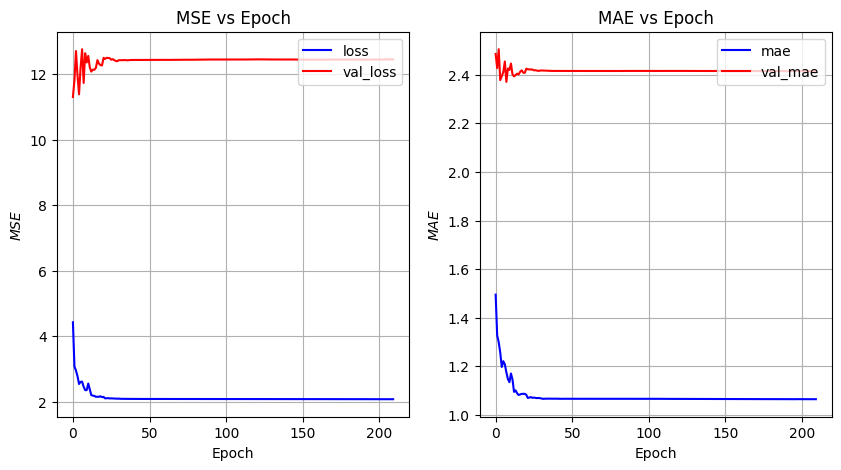

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot( historial.epoch, historial.history['loss'],     'b',label='loss')
plt.plot( historial.epoch, historial.history['val_loss'], 'r',label='val_loss')
plt.title(u'MSE vs Epoch')
plt.xlabel(u'Epoch')
plt.ylabel(r'$MSE$')
plt.legend(loc='upper right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot( historial.epoch, historial.history['mae'],     'b',label='mae')
plt.plot( historial.epoch, historial.history['val_mae'], 'r',label='val_mae')
plt.title(u'MAE vs Epoch')
plt.xlabel(u'Epoch')
plt.ylabel(r'$MAE$')
plt.legend(loc='upper right')
plt.grid(True)

# plt.ylim([0, np.max(historial.history['loss'])])
plt.show()
plt.savefig("mse_y_mae_por_epochs.jpg", dpi=100)
plt.clf()

#Ejemplo de gráficos esperados

In [ ]:
prediction_test = mejorModelo.predict(X_test_std)

4/4 [==============================] - 0s 3ms/step


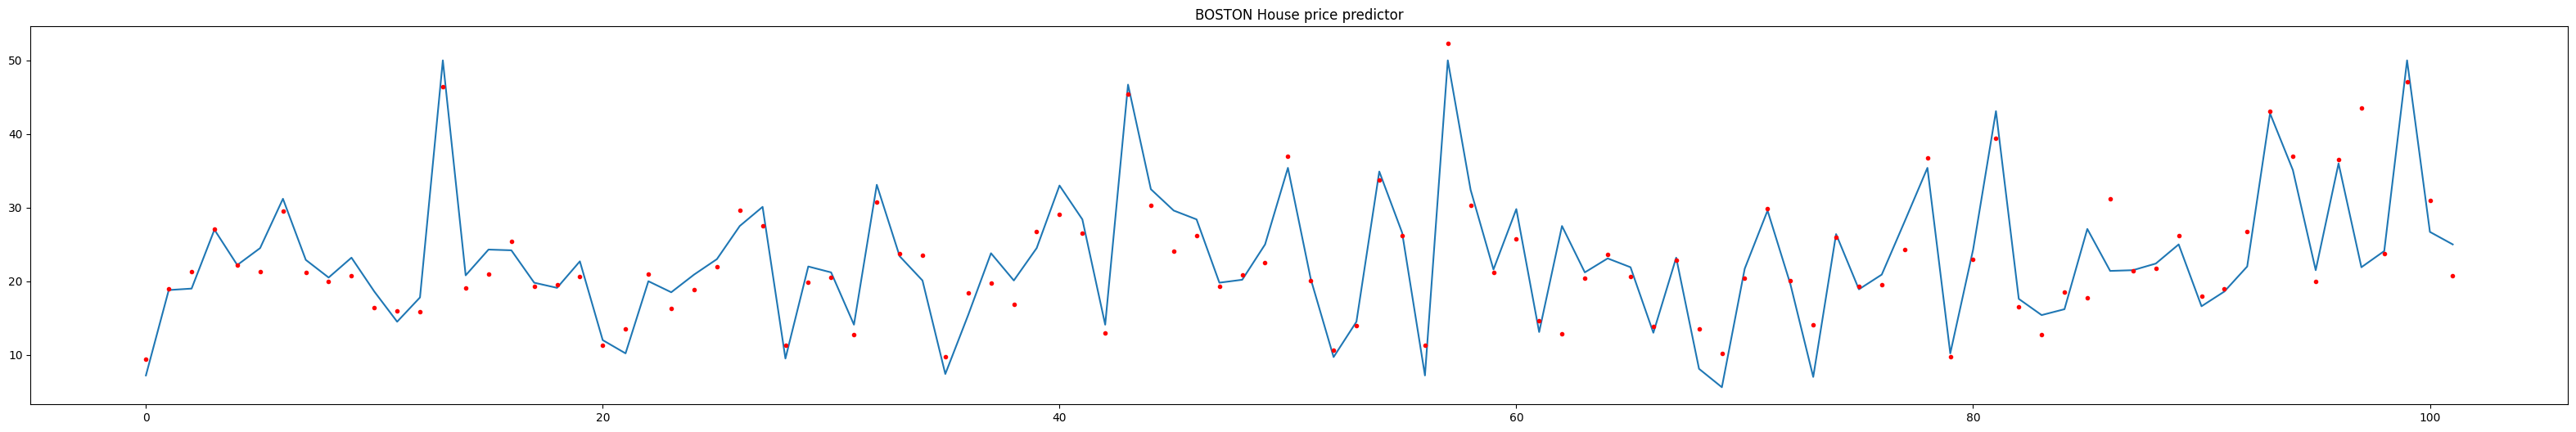

In [ ]:
plt.figure(figsize=(40, 6))
plt.plot(range(y_test.shape[0]), y_test)
plt.plot(range(prediction_test.shape[0]), prediction_test, '.r')
plt.title("BOSTON House price predictor")
plt.savefig("grafica1_boston.jpg")
plt.show()



---



---

